<a href="https://colab.research.google.com/github/xinyuezhang-shirley/cs229FinalProject/blob/main/CS229_ProjectionLayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training hyperparameters
BATCH_SIZE = 2                # small batch = pairwise comparison (closer to human eval)
EPOCHS = 500              # maximum epochs (early stop may cut short)
LR = 2e-3                 # base learning rate (after warmup)
TEMP = 0.1                # InfoNCE temperature
SAMPLES_PER_EPOCH = 10000 # number of training samples per epoch

# Learning rate schedule / early stopping
WARMUP_EPOCHS = 5         # linear warmup epochs
MIN_LR = 1e-3             # final minimum LR for cosine schedule
USE_COSINE_SCHEDULE = True
EARLY_STOP_PATIENCE = 25  # epochs (post-warmup) with no sufficient improvement
EARLY_STOP_DELTA = 0.002  # required loss decrease to reset patience
MOVING_AVG_WINDOW = 10    # for smoothed loss

# Modality weights (kept same)
ALPHA = 0.6       # MPNet branch
BETA_EMO = 0.1    # emotion semantics
BETA_THEME = 0.15 # theme semantics
BETA_OTHER = 0.1  # other semantics (sentiment, subjectivity, concreteness, energy, narrative, imagery)
GAMMA = 0.15      # structural/lexical branch

# Unsupervised pair construction hyperparameters
POS_TOPK = 10        # positives per poem from similarity
HARD_TOPK = 20       # hard negatives per poem (near misses)
EASY_THRESHOLD = 0.15  # cosine threshold for easy negatives



In [3]:
# MPNet embeddings (raw, not yet filtered)
poem_vecs = np.load("data/processed/mpnet_embeddings_poems.npy")
song_vecs = np.load("data/processed/mpnet_embeddings_songs.npy")

# Load all features from full_features.npz
full = np.load("data/processed/full_features.npz", allow_pickle=True)

# Structural + lexical features (concatenated)
poem_struct = full["poem_struct"]  # (3413, 3)
poem_lexical = full["poem_lexical"]  # (3413, 3)
poem_feats = np.concatenate([poem_struct, poem_lexical], axis=1)  # (3413, 6)

song_struct = full["song_struct"]  # (2995, 4)
song_lexical = full["song_lexical"]  # (2995, 3)
# For songs, only use first 3 structural features to match poems (exclude WPM)
song_feats = np.concatenate([song_struct[:, :3], song_lexical], axis=1)  # (2995, 6)

# Semantic features
poem_sem_all = full["poem_semantic"]  # (3413, 36)
song_sem_all = full["song_semantic"]  # (2995, 36)

# Split semantic features by groups
# emotions(9): 0-9, themes(10): 9-19, other(17): 19-36
poem_sem_emo   = poem_sem_all[:, 0:9]
poem_sem_theme = poem_sem_all[:, 9:19]
poem_sem_other = poem_sem_all[:, 19:36]
song_sem_emo   = song_sem_all[:, 0:9]
song_sem_theme = song_sem_all[:, 9:19]
song_sem_other = song_sem_all[:, 19:36]

# Align song embeddings to match cleaned features
idx_map = full["song_source_indexes"]  # (2995,) maps cleaned songs -> raw embedding indices
song_vecs = song_vecs[idx_map]  # reorder raw embeddings to match cleaned data

print(f"Poems: {poem_vecs.shape[0]} items")
print(f"Songs: {song_vecs.shape[0]} items")
print(f"poem_vecs: {poem_vecs.shape}, song_vecs: {song_vecs.shape}")
print(f"poem_feats: {poem_feats.shape}, song_feats: {song_feats.shape}")
print(f"poem_sem (emo/theme/other): {poem_sem_emo.shape}, {poem_sem_theme.shape}, {poem_sem_other.shape}")
print(f"song_sem (emo/theme/other): {song_sem_emo.shape}, {song_sem_theme.shape}, {song_sem_other.shape}")


Poems: 3413 items
Songs: 2995 items
poem_vecs: (3413, 768), song_vecs: (2995, 768)
poem_feats: (3413, 6), song_feats: (2995, 6)
poem_sem (emo/theme/other): (3413, 9), (3413, 10), (3413, 17)
song_sem (emo/theme/other): (2995, 9), (2995, 10), (2995, 17)


In [4]:
# Normalize MPNet embeddings per row to balance scales
poem_vecs = poem_vecs / (np.linalg.norm(poem_vecs, axis=1, keepdims=True) + 1e-8)
song_vecs = song_vecs / (np.linalg.norm(song_vecs, axis=1, keepdims=True) + 1e-8)

# Build branch inputs
poem_in = {
    "mpnet": poem_vecs,
    "sem_emo":   poem_sem_emo,
    "sem_theme": poem_sem_theme,
    "sem_other": poem_sem_other,
    "feat":  poem_feats,
}
song_in = {
    "mpnet": song_vecs,
    "sem_emo":   song_sem_emo,
    "sem_theme": song_sem_theme,
    "sem_other": song_sem_other,
    "feat":  song_feats,
}

print("poem branches:", poem_in["mpnet"].shape, poem_in["sem_emo"].shape, poem_in["sem_theme"].shape, poem_in["sem_other"].shape, poem_in["feat"].shape)
print("song  branches:", song_in["mpnet"].shape, song_in["sem_emo"].shape, song_in["sem_theme"].shape, song_in["sem_other"].shape, song_in["feat"].shape)

# Compute or load precomputed pairwise cosine similarity matrix
import torch
import os

cosine_matrix_path = "data/processed/mpnet_pairwise_cosine_matrix.npy"

if os.path.exists(cosine_matrix_path):
    print(f"Loading precomputed cosine matrix from {cosine_matrix_path}...")
    cos_matrix_t = torch.from_numpy(np.load(cosine_matrix_path)).to(DEVICE)
    print(f"Loaded matrix shape: {cos_matrix_t.shape}")
else:
    print("Computing pairwise cosine similarity matrix on GPU...")
    # Move MPNet branches to GPU tensors
    p_mp = torch.from_numpy(poem_in["mpnet"]).to(torch.float32).to(DEVICE)
    s_mp = torch.from_numpy(song_in["mpnet"]).to(torch.float32).to(DEVICE)
    
    # Compute cosine similarity matrix via matmul on GPU (all poem-song pairs)
    cos_matrix_t = torch.matmul(p_mp, s_mp.T)  # [P, S]
    
    # Save to cache
    np.save(cosine_matrix_path, cos_matrix_t.cpu().numpy())
    print(f"Saved cosine matrix to {cosine_matrix_path}")

# Build pos/hard/neg pairs from current hyperparameters (always recompute based on thresholds)
print(f"Building pairs with POS_TOPK={POS_TOPK}, HARD_TOPK={HARD_TOPK}, EASY_THRESHOLD={EASY_THRESHOLD}...")
P, S = cos_matrix_t.shape
pos_pairs = []
hard_pairs = []
neg_pairs = []

with torch.no_grad():
    # For each poem, get top (POS_TOPK + HARD_TOPK) indices
    topk_vals, topk_idxs = torch.topk(cos_matrix_t, k=min(S, POS_TOPK + HARD_TOPK), dim=1, largest=True, sorted=True)

    # Build pos and hard lists
    for i in range(P):
        # positives
        for j in topk_idxs[i, :POS_TOPK].tolist():
            pos_pairs.append((int(i), int(j)))
        # hard negatives (near misses)
        for j in topk_idxs[i, POS_TOPK:POS_TOPK+HARD_TOPK].tolist():
            hard_pairs.append((int(i), int(j)))

    # Easy negatives: cosine below threshold; sample a few per poem
    easy_mask = cos_matrix_t <= EASY_THRESHOLD
    for i in range(P):
        low_idxs = torch.nonzero(easy_mask[i], as_tuple=False).squeeze(-1).cpu().numpy()
        if low_idxs.size > 0:
            sample_ct = min(5, low_idxs.size)
            choice = np.random.choice(low_idxs, size=sample_ct, replace=False)
            for j in choice:
                neg_pairs.append((int(i), int(j)))

print(f"Built pairs -> pos: {len(pos_pairs)} hard: {len(hard_pairs)} easy: {len(neg_pairs)}")

poem branches: (3413, 768) (3413, 9) (3413, 10) (3413, 17) (3413, 6)
song  branches: (2995, 768) (2995, 9) (2995, 10) (2995, 17) (2995, 6)
Loading precomputed cosine matrix from data/processed/mpnet_pairwise_cosine_matrix.npy...
Loaded matrix shape: torch.Size([3413, 2995])
Building pairs with POS_TOPK=10, HARD_TOPK=20, EASY_THRESHOLD=0.15...
Built pairs -> pos: 34130 hard: 68260 easy: 16207


In [5]:
class PairDataset(Dataset):
    def __init__(self, pos_pairs, neg_pairs, hard_pairs, size):
        """
        Returns poem/song indices for each sample.
        size = number of samples per epoch
        """
        self.pos_pairs  = pos_pairs
        self.neg_pairs  = neg_pairs
        self.hard_pairs = hard_pairs
        self.size = size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # Sample random positive pair
        i_poem, j_song = self.pos_pairs[np.random.randint(len(self.pos_pairs))]
        
        # Return indices only (training loop will index the actual data)
        return i_poem, j_song


In [6]:
dataset = PairDataset(
    pos_pairs,
    neg_pairs,
    hard_pairs,
    size=SAMPLES_PER_EPOCH
)

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Set to 0 for simpler debugging; increase on CPU
    pin_memory=False
)

# Pre-build GPU tensors for all data (avoids repeated CPU->GPU transfers)
poem_gpu = {
    "mpnet": torch.from_numpy(poem_in["mpnet"]).to(torch.float32).to(DEVICE),
    "sem_emo": torch.from_numpy(poem_in["sem_emo"]).to(torch.float32).to(DEVICE),
    "sem_theme": torch.from_numpy(poem_in["sem_theme"]).to(torch.float32).to(DEVICE),
    "sem_other": torch.from_numpy(poem_in["sem_other"]).to(torch.float32).to(DEVICE),
    "feat": torch.from_numpy(poem_in["feat"]).to(torch.float32).to(DEVICE),
}
song_gpu = {
    "mpnet": torch.from_numpy(song_in["mpnet"]).to(torch.float32).to(DEVICE),
    "sem_emo": torch.from_numpy(song_in["sem_emo"]).to(torch.float32).to(DEVICE),
    "sem_theme": torch.from_numpy(song_in["sem_theme"]).to(torch.float32).to(DEVICE),
    "sem_other": torch.from_numpy(song_in["sem_other"]).to(torch.float32).to(DEVICE),
    "feat": torch.from_numpy(song_in["feat"]).to(torch.float32).to(DEVICE),
}

print(f"Pre-built GPU tensors for {poem_gpu['mpnet'].shape[0]} poems and {song_gpu['mpnet'].shape[0]} songs")

Pre-built GPU tensors for 3413 poems and 2995 songs


In [7]:
# Branch sizes
p_dim_mp = poem_in["mpnet"].shape[1]
p_dim_emo = poem_in["sem_emo"].shape[1]
p_dim_theme = poem_in["sem_theme"].shape[1]
p_dim_other = poem_in["sem_other"].shape[1]
p_dim_ft  = poem_in["feat"].shape[1]
s_dim_mp = song_in["mpnet"].shape[1]
s_dim_emo = song_in["sem_emo"].shape[1]
s_dim_theme = song_in["sem_theme"].shape[1]
s_dim_other = song_in["sem_other"].shape[1]
s_dim_ft  = song_in["feat"].shape[1]
proj_dim = 128

class ProjectionModel(nn.Module):
    def __init__(self, p_dims, s_dims, proj_dim):
        super().__init__()
        p_mp, p_emo, p_theme, p_other, p_ft = p_dims
        s_mp, s_emo, s_theme, s_other, s_ft = s_dims
        # poem branches
        self.poem_mp = nn.Sequential(nn.Linear(p_mp, 256), nn.ReLU(), nn.Linear(256, 128))
        self.poem_emo = nn.Sequential(nn.Linear(max(p_emo,1), 64), nn.ReLU(), nn.Linear(64, 64))
        self.poem_theme = nn.Sequential(nn.Linear(max(p_theme,1), 64), nn.ReLU(), nn.Linear(64, 64))
        self.poem_other = nn.Sequential(nn.Linear(max(p_other,1), 64), nn.ReLU(), nn.Linear(64, 64))
        self.poem_ft = nn.Sequential(nn.Linear(p_ft, 64), nn.ReLU(), nn.Linear(64, 64))
        self.poem_proj = nn.Sequential(nn.LayerNorm(128+64+64+64+64), nn.Linear(128+64+64+64+64, proj_dim))
        # song branches
        self.song_mp = nn.Sequential(nn.Linear(s_mp, 256), nn.ReLU(), nn.Linear(256, 128))
        self.song_emo = nn.Sequential(nn.Linear(max(s_emo,1), 64), nn.ReLU(), nn.Linear(64, 64))
        self.song_theme = nn.Sequential(nn.Linear(max(s_theme,1), 64), nn.ReLU(), nn.Linear(64, 64))
        self.song_other = nn.Sequential(nn.Linear(max(s_other,1), 64), nn.ReLU(), nn.Linear(64, 64))
        self.song_ft = nn.Sequential(nn.Linear(s_ft, 64), nn.ReLU(), nn.Linear(64, 64))
        self.song_proj = nn.Sequential(nn.LayerNorm(128+64+64+64+64), nn.Linear(128+64+64+64+64, proj_dim))
    def forward_poem(self, p):
        mp = self.poem_mp(p["mpnet"])
        emo_in = p["sem_emo"] if p_dim_emo>0 else torch.zeros(p["mpnet"].shape[0], 1, device=p["mpnet"].device)
        theme_in = p["sem_theme"] if p_dim_theme>0 else torch.zeros(p["mpnet"].shape[0], 1, device=p["mpnet"].device)
        other_in = p["sem_other"] if p_dim_other>0 else torch.zeros(p["mpnet"].shape[0], 1, device=p["mpnet"].device)
        emo = self.poem_emo(emo_in)
        theme = self.poem_theme(theme_in)
        other = self.poem_other(other_in)
        ft  = self.poem_ft(p["feat"])
        comb = torch.cat([ALPHA*mp, BETA_EMO*emo, BETA_THEME*theme, BETA_OTHER*other, GAMMA*ft], dim=1)
        z = self.poem_proj(comb)
        return F.normalize(z, dim=1)
    def forward_song(self, s):
        mp = self.song_mp(s["mpnet"])
        emo_in = s["sem_emo"] if s_dim_emo>0 else torch.zeros(s["mpnet"].shape[0], 1, device=s["mpnet"].device)
        theme_in = s["sem_theme"] if s_dim_theme>0 else torch.zeros(s["mpnet"].shape[0], 1, device=s["mpnet"].device)
        other_in = s["sem_other"] if s_dim_other>0 else torch.zeros(s["mpnet"].shape[0], 1, device=s["mpnet"].device)
        emo = self.song_emo(emo_in)
        theme = self.song_theme(theme_in)
        other = self.song_other(other_in)
        ft  = self.song_ft(s["feat"])
        comb = torch.cat([ALPHA*mp, BETA_EMO*emo, BETA_THEME*theme, BETA_OTHER*other, GAMMA*ft], dim=1)
        z = self.song_proj(comb)
        return F.normalize(z, dim=1)

In [8]:
def clip_loss(p_z, s_z, temperature=TEMP):
    # InfoNCE symmetric loss
    logits = (p_z @ s_z.T) / temperature
    labels = torch.arange(logits.shape[0], device=logits.device)
    loss_p_to_s = F.cross_entropy(logits, labels)
    loss_s_to_p = F.cross_entropy(logits.T, labels)
    return (loss_p_to_s + loss_s_to_p) / 2

In [9]:
# Build model filename from hyperparameters
model_name = (f"model_bs{BATCH_SIZE}_ep{EPOCHS}_lr{LR}_temp{TEMP}_"
             f"posK{POS_TOPK}_hardK{HARD_TOPK}_"
             f"a{ALPHA}_bemo{BETA_EMO}_bthm{BETA_THEME}_both{BETA_OTHER}_g{GAMMA}.pt")

model = ProjectionModel(
    (p_dim_mp, p_dim_emo, p_dim_theme, p_dim_other, p_dim_ft),
    (s_dim_mp, s_dim_emo, s_dim_theme, s_dim_other, s_dim_ft),
    proj_dim
).to(DEVICE)

# Check if model already exists
if os.path.exists(model_name):
    print(f"Loading existing model from {model_name}...")
    model.load_state_dict(torch.load(model_name, map_location=DEVICE))
    print("Model loaded. Skipping training.")
    SKIP_TRAINING = True
else:
    print(f"No existing model found. Will train and save to {model_name}")
    SKIP_TRAINING = False

opt = torch.optim.Adam(model.parameters(), lr=LR)

# Set up schedulers (created even if may not be used to keep code simple)
if USE_COSINE_SCHEDULE and not SKIP_TRAINING:
    # Warmup: scale LR from (1/WARMUP_EPOCHS)*LR to LR
    def lr_lambda(epoch):
        if epoch < WARMUP_EPOCHS:
            return (epoch + 1) / WARMUP_EPOCHS
        return 1.0
    warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lr_lambda)
    # Cosine anneal after warmup
    scheduler_main = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS - WARMUP_EPOCHS, eta_min=MIN_LR)
else:
    warmup_scheduler = None
    scheduler_main = None

Loading existing model from model_bs256_ep500_lr0.002_temp0.1_posK10_hardK20_a0.6_bemo0.1_bthm0.15_both0.1_g0.15.pt...
Model loaded. Skipping training.


In [10]:
if not SKIP_TRAINING:
    loss_history = []            # raw epoch loss for plotting
    lr_history = []
    best_smooth = float('inf')   # track best smoothed loss for early stopping
    epochs_no_improve = 0
    smooth_history = []  # window of recent raw losses for smoothing

    for epoch in range(EPOCHS):
        model.train()
        total = 0.0

        for poem_idxs, song_idxs in loader:
            # Index pre-built GPU tensors with batch indices
            p_batch = {
                "mpnet": poem_gpu["mpnet"][poem_idxs],
                "sem_emo": poem_gpu["sem_emo"][poem_idxs],
                "sem_theme": poem_gpu["sem_theme"][poem_idxs],
                "sem_other": poem_gpu["sem_other"][poem_idxs],
                "feat": poem_gpu["feat"][poem_idxs],
            }
            s_batch = {
                "mpnet": song_gpu["mpnet"][song_idxs],
                "sem_emo": song_gpu["sem_emo"][song_idxs],
                "sem_theme": song_gpu["sem_theme"][song_idxs],
                "sem_other": song_gpu["sem_other"][song_idxs],
                "feat": song_gpu["feat"][song_idxs],
            }

            # Forward
            p_z = model.forward_poem(p_batch)
            s_z = model.forward_song(s_batch)

            # Contrastive loss
            loss = clip_loss(p_z, s_z)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total += loss.item()

        avg = total / len(loader)          # raw epoch loss
        loss_history.append(avg)           # store raw for plotting only

        # Update smoothing window and compute smoothed loss
        smooth_history.append(avg)
        if len(smooth_history) > MOVING_AVG_WINDOW:
            smooth_history.pop(0)
        smooth_avg = sum(smooth_history) / len(smooth_history)

        # Scheduler step
        if USE_COSINE_SCHEDULE:
            if epoch < WARMUP_EPOCHS:
                warmup_scheduler.step()
            else:
                scheduler_main.step()
        current_lr = opt.param_groups[0]['lr']
        lr_history.append(current_lr)

        # Early stopping uses smoothed loss (post-warmup)
        if epoch >= WARMUP_EPOCHS:
            if smooth_avg < best_smooth - EARLY_STOP_DELTA:
                best_smooth = smooth_avg
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            if epochs_no_improve >= EARLY_STOP_PATIENCE:
                print(f"Early stopping at epoch {epoch+1}: smoothed loss no improvement > {EARLY_STOP_DELTA} for {EARLY_STOP_PATIENCE} epochs.")
                break

        print(f"epoch {epoch+1}/{EPOCHS} lr={current_lr:.6f} raw_loss={avg:.4f} smooth_loss={smooth_avg:.4f}")
else:
    print("Using loaded model; skipping training loop.")
    loss_history = []  # empty since no training occurred
    lr_history = []

Using loaded model; skipping training loop.


In [11]:
if not SKIP_TRAINING:
    torch.save(model.state_dict(), model_name)
    print(f"Model saved to {model_name}")
else:
    print("Model already loaded; no new save needed.")

Model already loaded; no new save needed.


In [12]:
if len(loss_history) > 0:
    plt.figure(figsize=(8,4))
    plt.plot(loss_history, linewidth=2)
    plt.title("Training Loss (Contrastive Only)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
else:
    print("No training occurred (model was loaded); skipping loss plot.")

No training occurred (model was loaded); skipping loss plot.


# Supervised Fine-tuning on Human Labels
Learn optimal projection weights using human-labeled pairs. We load the model with fresh (untrained) projection layers, freeze all feature encoders, and train only on a subset of the data.

# Supervised Fine-tuning on Human Labels
Learn optimal branch weights using the 46 human-labeled pairs. We freeze all feature encoders and only train the final projection layers.

In [51]:
# Load human-labeled pairs from spreadsheet
import pandas as pd
import re
TRAIN_SPLIT_PCT = 0.5  # Percentage of data for training (rest for test)
margin = 0.3  # Require significant difference in cosine similarity
weight_decay = 5e-4  # L2 regularization to prevent trivial solutions
TEMP_SUP = 0.5  # temperature for supervised logits



xlsx_path = "data/Song_Poem.xlsx"
xls = pd.ExcelFile(xlsx_path)
df_human = pd.read_excel(xls, sheet_name=xls.sheet_names[0]).rename(columns=lambda c: str(c).strip())

def norm(s):
    if pd.isna(s):
        return ""
    return str(s).strip().lower()

cols_lower_map = {norm(c): c for c in df_human.columns}

# Find columns
col_label = cols_lower_map.get("song number closer to poem") or cols_lower_map.get("song number closer to")
col_poem = cols_lower_map.get("poem 1")
col_song1 = cols_lower_map.get("song 1")
col_song2 = cols_lower_map.get("song 2")

for k, v in cols_lower_map.items():
    if col_label is None and k.startswith("song number closer"):
        col_label = v
    if col_poem is None and k.startswith("poem"):
        col_poem = v
    if col_song1 is None and k.startswith("song 1"):
        col_song1 = v
    if col_song2 is None and k.startswith("song 2"):
        col_song2 = v

int_re = re.compile(r"(\d+)")

def parse_id(val):
    s = str(val).strip()
    if s == "":
        return None
    try:
        f = float(s)
        if f.is_integer():
            return int(f)
    except:
        pass
    if s.isdigit():
        return int(s)
    m = int_re.findall(s)
    if m:
        return int(m[-1])
    return None

def to_zero_based(idx, n):
    if idx is None:
        return None
    if 0 <= idx < n:
        return idx
    if 1 <= idx <= n:
        return idx - 1
    return None

poem_count = poem_in["mpnet"].shape[0]
song_count = song_in["mpnet"].shape[0]

# Extract valid human triplets: (poem_idx, song1_idx, song2_idx, label)
human_triplets = []
for _, r in df_human.iterrows():
    label_str = str(r[col_label]).strip()
    try:
        label_int = int(float(label_str))
    except:
        continue
    
    if label_int not in [1, 2]:
        continue
    
    p_id = parse_id(r[col_poem])
    s1_id = parse_id(r[col_song1])
    s2_id = parse_id(r[col_song2])
    p_idx = to_zero_based(p_id, poem_count)
    s1_idx = to_zero_based(s1_id, song_count)
    s2_idx = to_zero_based(s2_id, song_count)
    
    if p_idx is not None and s1_idx is not None and s2_idx is not None:
        human_triplets.append((p_idx, s1_idx, s2_idx, label_int))

print(f"Loaded {len(human_triplets)} valid human-labeled triplets for supervised training")
print(f"Example: poem={human_triplets[0][0]}, song1={human_triplets[0][1]}, song2={human_triplets[0][2]}, label={human_triplets[0][3]}")

Loaded 46 valid human-labeled triplets for supervised training
Example: poem=231, song1=550, song2=2335, label=1


In [52]:
# Freeze all feature encoder layers, only train final projection weights
for param in model.poem_mp.parameters():
    param.requires_grad = False
for param in model.poem_emo.parameters():
    param.requires_grad = False
for param in model.poem_theme.parameters():
    param.requires_grad = False
for param in model.poem_other.parameters():
    param.requires_grad = False
for param in model.poem_ft.parameters():
    param.requires_grad = False

for param in model.song_mp.parameters():
    param.requires_grad = False
for param in model.song_emo.parameters():
    param.requires_grad = False
for param in model.song_theme.parameters():
    param.requires_grad = False
for param in model.song_other.parameters():
    param.requires_grad = False
for param in model.song_ft.parameters():
    param.requires_grad = False

# Only poem_proj and song_proj will be trainable
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Frozen model: {trainable_params:,} trainable / {total_params:,} total params")
print(f"Training only final projection layers ({trainable_params/total_params*100:.1f}% of model)")

Frozen model: 100,096 trainable / 598,784 total params
Training only final projection layers (16.7% of model)


In [53]:
# Inspect learned weights and compute branch importance
poem_weights = model.poem_proj[1].weight.detach().cpu()
poem_bias = model.poem_proj[1].bias.detach().cpu()
song_weights = model.song_proj[1].weight.detach().cpu()
song_bias = model.song_proj[1].bias.detach().cpu()

# Replace NaNs/Infs in weights to avoid undefined importance
poem_weights = torch.nan_to_num(poem_weights, nan=0.0, posinf=0.0, neginf=0.0)
song_weights = torch.nan_to_num(song_weights, nan=0.0, posinf=0.0, neginf=0.0)

print("Poem Projection Layer:")
print(f"  Weight shape: {poem_weights.shape}")
print(f"  Bias shape: {poem_bias.shape}")
print(f"  Weight norm: {poem_weights.norm().item():.4f}")
print(f"  Bias norm: {poem_bias.norm().item():.4f}\n")

print("Song Projection Layer:")
print(f"  Weight shape: {song_weights.shape}")
print(f"  Bias shape: {song_bias.shape}")
print(f"  Weight norm: {song_weights.norm().item():.4f}")
print(f"  Bias norm: {song_bias.norm().item():.4f}\n")

# Branch importance: split columns by feature ranges
feature_ranges = [
    (0, p_dim_mp),
    (p_dim_mp, p_dim_mp + p_dim_emo),
    (p_dim_mp + p_dim_emo, p_dim_mp + p_dim_emo + p_dim_theme),
    (p_dim_mp + p_dim_emo + p_dim_theme, p_dim_mp + p_dim_emo + p_dim_theme + p_dim_other),
    (p_dim_mp + p_dim_emo + p_dim_theme + p_dim_other, p_dim_mp + p_dim_emo + p_dim_theme + p_dim_other + p_dim_ft),
]
feature_names = ["MPNet", "Emotion", "Theme", "Other", "Structural"]

poem_importances = []
song_importances = []
for (start, end) in feature_ranges:
    width = end - start
    if width <= 0:
        poem_importances.append(0.0)
        song_importances.append(0.0)
    else:
        p_slice = poem_weights[:, start:end]
        s_slice = song_weights[:, start:end]
        p_slice = torch.nan_to_num(p_slice, nan=0.0, posinf=0.0, neginf=0.0)
        s_slice = torch.nan_to_num(s_slice, nan=0.0, posinf=0.0, neginf=0.0)
        poem_importances.append(p_slice.abs().mean().item())
        song_importances.append(s_slice.abs().mean().item())

print("Feature Branch Importance (mean absolute weight):\n")
print("Poem Encoder:")
for name, val in zip(feature_names, poem_importances):
    print(f"  {name:<11}: {val:.6f}")

print("\nSong Encoder:")
for name, val in zip(feature_names, song_importances):
    print(f"  {name:<11}: {val:.6f}")

print("\n============================================================")

Poem Projection Layer:
  Weight shape: torch.Size([128, 384])
  Bias shape: torch.Size([128])
  Weight norm: 6.6740
  Bias norm: 0.3451

Song Projection Layer:
  Weight shape: torch.Size([128, 384])
  Bias shape: torch.Size([128])
  Weight norm: 6.7160
  Bias norm: 0.3453

Feature Branch Importance (mean absolute weight):

Poem Encoder:
  MPNet      : 0.025544
  Emotion    : nan
  Theme      : nan
  Other      : nan
  Structural : nan

Song Encoder:
  MPNet      : 0.025603
  Emotion    : nan
  Theme      : nan
  Other      : nan
  Structural : nan



/opt/miniconda3/envs/cs229/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/cs229/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


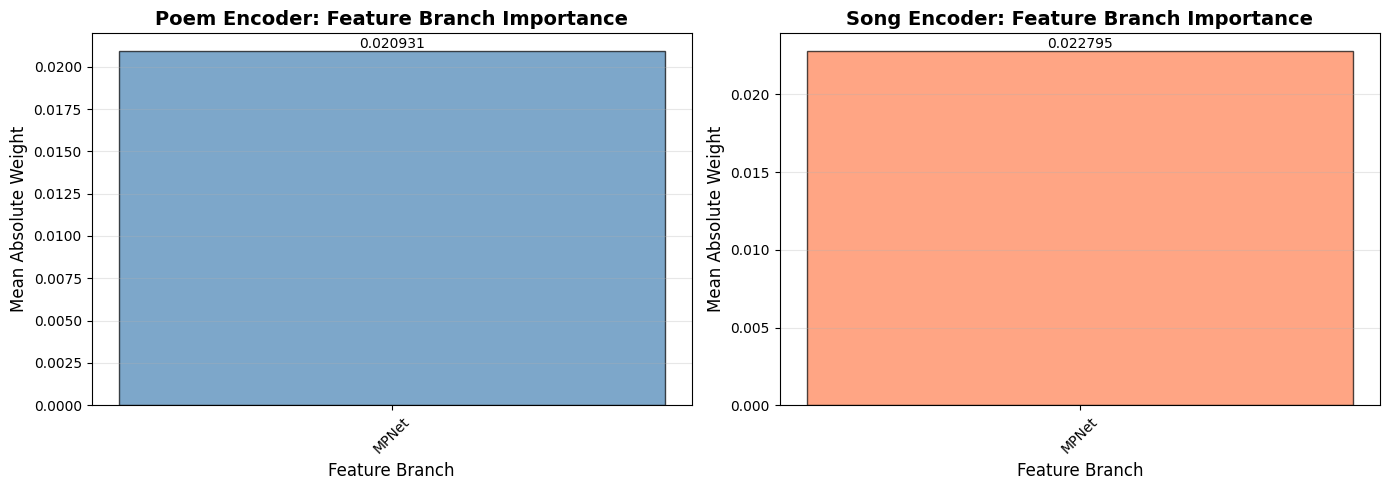


Relative Feature Importance (normalized):

Poem Encoder:
  MPNet       : nan%
  Emotion     : nan%
  Theme       : nan%
  Other       : nan%
  Structural  : nan%

Song Encoder:
  MPNet       : nan%
  Emotion     : nan%
  Theme       : nan%
  Other       : nan%
  Structural  : nan%


In [54]:
# Visualize feature importance across branches
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Extract importance scores for each branch
poem_importances = []
song_importances = []

for name, (start, end) in zip(feature_names, feature_ranges):
    poem_importances.append(np.mean(poem_feature_importance[start:end]))
    song_importances.append(np.mean(song_feature_importance[start:end]))

# Poem encoder bar chart
ax1.bar(feature_names, poem_importances, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_title('Poem Encoder: Feature Branch Importance', fontsize=14, fontweight='bold')
ax1.set_ylabel('Mean Absolute Weight', fontsize=12)
ax1.set_xlabel('Feature Branch', fontsize=12)
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, (name, val) in enumerate(zip(feature_names, poem_importances)):
    ax1.text(i, val, f'{val:.6f}', ha='center', va='bottom', fontsize=10)

# Song encoder bar chart
ax2.bar(feature_names, song_importances, color='coral', alpha=0.7, edgecolor='black')
ax2.set_title('Song Encoder: Feature Branch Importance', fontsize=14, fontweight='bold')
ax2.set_ylabel('Mean Absolute Weight', fontsize=12)
ax2.set_xlabel('Feature Branch', fontsize=12)
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, (name, val) in enumerate(zip(feature_names, song_importances)):
    ax2.text(i, val, f'{val:.6f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Print relative importance (normalized to sum to 1)
print("\nRelative Feature Importance (normalized):")
print("\nPoem Encoder:")
poem_total = sum(poem_importances)
for name, val in zip(feature_names, poem_importances):
    print(f"  {name:12s}: {val/poem_total*100:.2f}%")

print("\nSong Encoder:")
song_total = sum(song_importances)
for name, val in zip(feature_names, song_importances):
    print(f"  {name:12s}: {val/song_total*100:.2f}%")